In [1]:
# customary imports:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

## 1. Download the white blood cell classification data
The data is hosted online, so we can use the linux command `wget` to download it. If you run into any issues with the data download, please just share your challenges via Slack and we can help sort them out.

## Note about downloading and unzipping the dataset
Instead of working on Google Colab, I prefer to work locally on Anaconda Jupyter Notebook installed on my own computer. However, my computer has Windows operating system so that I could not simply run the Linux commands. To address this issue, I decide to run the "!wget" Linux command on Google Colab first, to download and save "data.zip" file to my own Google Drive. Then, I manually download the dataset from Google Drive to my local computer and I manually unzip the dataset.  
I hope this explanation helps clarify why I comment out these Linux commands. Thanks very much for your understanding.

In [2]:
# !wget -O data.zip https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded

In [3]:
# !unzip /content/data.zip

In [4]:
# !unzip /content/PBC_dataset_normal_DIB.zip > /dev/null

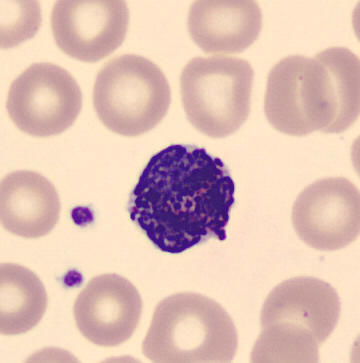

In [5]:
# loading a sample image
sample_image = Image.open("PBC_dataset_normal_DIB/basophil/BA_100102.jpg")
sample_image

(12432, 128, 128, 1) (12432, 8)
(3109, 128, 128, 1) (3109, 8)


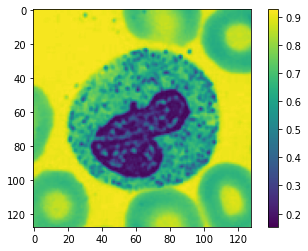

In [6]:
def load_and_crop(image_path, crop_size, normalized=True):
    image = Image.open(image_path).resize([200,200])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# code to load all the data, assuming dataset is at PBC_dataset_normal_DIB relative path
cell_types = ['basophil', 'eosinophil', 'erthroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
cell_inds = np.arange(0, len(cell_types))
x_data = []
y_data = []
for cell_ind in cell_inds:
    all_images = glob.glob(os.path.join('PBC_dataset_normal_DIB', cell_types[cell_ind], '*.jpg'))
    x_data += [load_and_crop(image_path, 128) for image_path in all_images]
    y_data += [cell_ind]*len(all_images)

# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(cell_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(cell_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [7]:
print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)
print(type(x_val), x_val.shape)
print(type(y_val), y_val.shape)

<class 'numpy.ndarray'> (12432, 128, 128, 1)
<class 'numpy.ndarray'> (12432, 8)
<class 'numpy.ndarray'> (3109, 128, 128, 1)
<class 'numpy.ndarray'> (3109, 8)


## 2. Define a keras model
You can either use the sequential model class, or the functional model declaration

(a) Please define your model with the following layers:
1. A convolutional layer with a 5x5 kernel and stride of 1
2. A convolutional layer with a 5x5 kernel and stride of 1
3. A pooling layer (Instead of this, you could also increase the stride in the second layer)
4. A convolutional layer with a 5x5 kernel and stride of 1
5. A convolutional layer with a 5x5 kernel and stride of 1
6. A pooling layer (Instead of this, you could also increase the stride in the fifth layer)
7. A Dense layer
8. Output layer of size 8

You are free to choose the sizes, number of channels and activations (i.e., the employed non-linearity) for each of the layers.

(b) Now, please comment out the pooling layer in step 3 and step 6, and instead increase the stride in the appropriate layers to achieve the same down-sampling effect (i.e., to reduce the size of the tensor in the same way as pooling) 

(c) After defining the model, you should define an optimizer and set a learning rate. You also should pick a loss function.

(d) Run the optimization for 10-15 epochs and monitor the training and validation loss and accuracy. After training is done, please plot two graphs, one showing the training and validation losses as two curves within the same plot, and a second graph that shows the the training and validation accuracies as two curves within the same plot. For both plots, please let epoch be the horizontal axis.

At the end of training, you should be able obtain an accuracy better than 80%.

You may refer to the notebook from the TA session or any online TensorFlow resources for guidance.

In [8]:
# your code here
# Question 2(a) - Define the CNN model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding="same", activation="relu"),   # Step 1
    
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu"),   # Step 2
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"),                        # Step 3
    
    ##############################################################################################################
    # Question 2(b) - If we comment out the pooling layer, the stride in the second layer (Step 2) should be 2.
    # When training the CNN model, I decide to keep the Max Pooling Layer and the original stride (strides = 1)
    
    # tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=2, padding="same", activation="relu"), # (Step 2)
    ##############################################################################################################
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="same", activation="relu"),  # Step 4
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation="relu"),  # Step 5
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"),                        # Step 6
    
    ##############################################################################################################
    # Question 2(b) - If we comment out the pooling layer, the stride in the fifth layer (Step 5) should be 2.
    # When training the CNN model, I decide to keep the Max Pooling Layer and the original stride (strides = 1)
    
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"), # (Step 5)
    ##############################################################################################################
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"),                                                # Step 7
    tf.keras.layers.Dense(8, activation="softmax")                                                     # Step 8
])

In [9]:
# Question 2(c)
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
cnn_model.compile(optimizer = model_optimizer, 
                  loss = "categorical_crossentropy", 
                  metrics = ["accuracy"])

In [10]:
# Question 2(d)
cnn_history = cnn_model.fit(x_train, y_train, 
                            epochs = 10, 
                            batch_size = 32, 
                            validation_data = (x_val, y_val))
cnn_model.save("Q2d_Model.h5")

Epoch 1/10
389/389 [==============================] - 102s 260ms/step - loss: 0.8296 - accuracy: 0.6832 - val_loss: 0.6536 - val_accuracy: 0.7324
Epoch 2/10
389/389 [==============================] - 101s 259ms/step - loss: 0.5078 - accuracy: 0.8142 - val_loss: 0.4970 - val_accuracy: 0.8141
Epoch 3/10
389/389 [==============================] - 102s 262ms/step - loss: 0.4289 - accuracy: 0.8450 - val_loss: 0.4999 - val_accuracy: 0.8089
Epoch 4/10
389/389 [==============================] - 102s 263ms/step - loss: 0.3708 - accuracy: 0.8662 - val_loss: 0.4112 - val_accuracy: 0.8495
Epoch 5/10
389/389 [==============================] - 102s 261ms/step - loss: 0.3186 - accuracy: 0.8856 - val_loss: 0.4102 - val_accuracy: 0.8498
Epoch 6/10
389/389 [==============================] - 103s 266ms/step - loss: 0.2782 - accuracy: 0.9005 - val_loss: 0.3526 - val_accuracy: 0.8729
Epoch 7/10
389/389 [==============================] - 104s 267ms/step - loss: 0.2448 - accuracy: 0.9127 - val_loss: 0.4225 -

In [8]:
# train_loss = np.asarray(cnn_history.history["loss"])
# train_acc = np.asarray(cnn_history.history["accuracy"])
# val_loss = np.asarray(cnn_history.history["val_loss"])
# val_acc = np.asarray(cnn_history.history["val_accuracy"])

# After restarting the notebook kernel, I will lose the above model training and validation history, so that
# I have to manually record the statistics based on the above training and validation print-out results.
train_loss = np.array([0.8296, 0.5078, 0.4289, 0.3708, 0.3186, 0.2782, 0.2448, 0.2112, 0.1871, 0.1627])
train_acc = np.array([0.6832, 0.8142, 0.8450, 0.8662, 0.8856, 0.9005, 0.9127, 0.9241, 0.9322, 0.9413])
val_loss = np.array([0.6536, 0.4970, 0.4999, 0.4112, 0.4102, 0.3526, 0.4225, 0.3936, 0.3598, 0.3832])
val_acc = np.array([0.7324, 0.8141, 0.8089, 0.8495, 0.8498, 0.8729, 0.8495, 0.8591, 0.8845, 0.8710])

In [15]:
def plot_graph (arr_train, arr_val, graph) :
    figure, axis = plt.subplots()
    num_epochs = np.linspace(1, len(arr_train), num = len(arr_val)).astype(int)
    axis.plot(num_epochs, arr_train, label = "Training %s" % graph, linewidth = 3)
    axis.plot(num_epochs, arr_val, label = "Validation %s" % graph, linewidth = 3)
    axis.set_xlabel("Epochs", fontsize = 14)
    axis.set_ylabel(graph, fontsize = 14)
    axis.grid()
    # figure.set_size_inches(8, 6)
    plt.xticks(num_epochs, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return None

In [57]:
def compare_models (arr1, arr2, comtype, modeldes) :
    figure, axis = plt.subplots()
    num_epochs = np.linspace(1, len(arr1), num = len(arr1)).astype(int)
    axis.plot(num_epochs, arr1, label = modeldes[0], linewidth = 3)
    axis.plot(num_epochs, arr2, label = modeldes[1], linewidth = 3)
    axis.set_title("Compare %s" % comtype, fontsize = 14)
    axis.set_xlabel("Epochs", fontsize = 14)
    axis.set_ylabel(comtype, fontsize = 14)
    axis.grid()
    # figure.set_size_inches(8, 6)
    plt.xticks(num_epochs, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return None

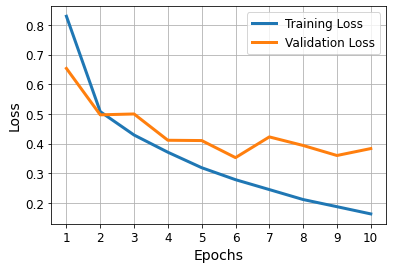

In [16]:
# Question 2(d)
plot_graph(train_loss, val_loss, "Loss")

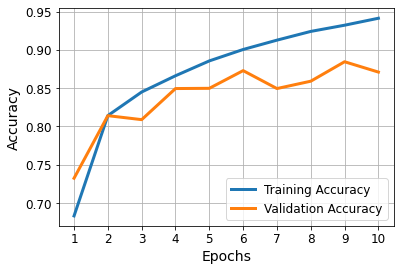

In [17]:
# Question 2(d)
plot_graph(train_acc, val_acc, "Accuracy")

To conclude, at the end of training, I am able to obtain an accuracy better than 80%.

## 3. How many weight parameters does your network have?
First try calculating this number by hand, and show your work (please type out the multiplications that you are performing to arrive at the final number.) Then, please verify the answer using Keras's autogenerated model summary.

### My solution for calculating this number by hand is written below.

Conv2D Layer 1: (5 * 5 + 1) * 4 = 26 * 4 = 104  
Conv2D Layer 2: (5 * 5 * 4 + 1) * 8 = 101 * 8 = 808  
Conv2D Layer 3: (5 * 5 * 8 + 1) * 16 = 201 * 16 = 3216  
Conv2D Layer 4: (5 * 5 * 16 + 1) * 32 = 401 * 32 = 12832  
Dense Layer: (32 * 32 * 32 + 1) * 64 = (32768 + 1) * 64 = 32769 * 64 = 2097216  
Output Layer: (64 + 1) * 8 = 65 * 8 = 520  
Therefore, the total number of trainable weight parameters should be:  
104 + 808 + 3216 + 12832 + 2097216 + 520 = 2114696  

In [38]:
model = tf.keras.models.load_model("Q2d_Model.h5")

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 4)       104       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       808       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

Therefore, my solution for calculating the total number of weight parameters by hand has been correctly verified.

## 4. Visualise filters
You can obtain weights in individual layers by running 
```
your_model_variable.layers[layer_index].get_weights()
```
(a) Plot all convolution kernels (i.e., each set of 5x5 weights) in your first convolutional layer.

(b) What is the variance of final weights in the first convolutional layer? 

(c) Also plot some of the convolutional weights in the second layer. What is the variance of the final weights in the second layer? 


In [40]:
def visualize_filters (cweights, figx = 10, figy = 8) :
    cfilters = cweights[0]
    num_in = cfilters.shape[2]
    num_out = cfilters.shape[3]
    rowx = 1
    plt.figure(figsize = (figx, figy))
    for i in range(num_out) :
        efilter = cfilters[:, :, :, i]
        for j in range(num_in) :
            axis = plt.subplot(num_out, num_in, rowx)
            axis.set_xticks([])
            axis.set_yticks([])
            plt.imshow(efilter[:, :, j], cmap = "gray")
            rowx = rowx + 1
    plt.show()
    return None

In [41]:
# 4(a)
cweights = model.layers[0].get_weights()

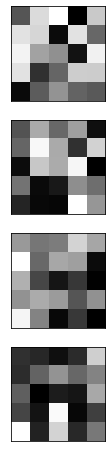

In [42]:
# 4(a)
visualize_filters(cweights)

In [43]:
# 4(b)
convlayer1_weights = cweights[0]
convlayer1_bias    = cweights[1]
variance1_weights  = np.var(convlayer1_weights)
variance1_bias     = np.var(convlayer1_bias)
print("The Variance of final weights in the first convolutional layer is %.5f" % variance1_weights)
print("The Variance of final bias    in the first comvolutional layer is %.5f" % variance1_bias)

The Variance of final weights in the first convolutional layer is 0.01582
The Variance of final bias    in the first comvolutional layer is 0.00059


In [44]:
# 4(c)
c2weights = model.layers[1].get_weights()

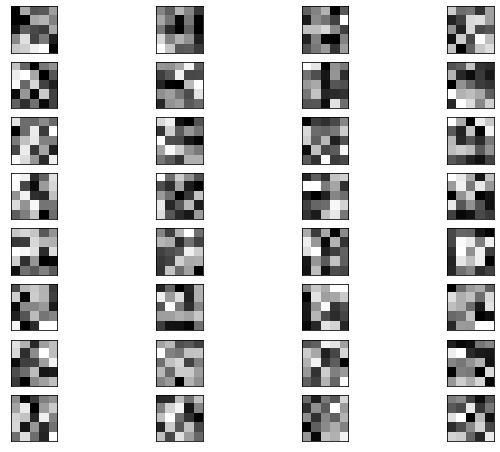

In [45]:
# 4(c)
visualize_filters(c2weights)

In [46]:
# 4(c)
convlayer2_weights = c2weights[0]
convlayer2_bias = c2weights[1]
var2_weights = np.var(convlayer2_weights)
var2_bias = np.var(convlayer2_bias)
print("The Variance of final weights of the second convolutional layer is %.5f" % var2_weights)
print("The Variance of final bias    of the second convolutional layer is %.5f" % var2_bias)

The Variance of final weights of the second convolutional layer is 0.00899
The Variance of final bias    of the second convolutional layer is 0.00059


## 5. Try playing with the learning rate
(a) Try to increase and decrease the learning rate and plot the training and validation loss and accuracy curves from part 2(d), for three different values of learning rate that you have tried. 

(b) Please comment on any trends that you can identify between how the plots change as a function of learning rate. Specifically, what happens to the slopes of the training loss and accuracy as a function of learning rate?

In [8]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"), 
    tf.keras.layers.Dense(8, activation="softmax")
])

In [9]:
# 5(a) - Increase the learning rate (compared with the baseline model in Question Part 2)
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model1.compile(optimizer = model_optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
history1 = model1.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/10
389/389 [==============================] - 104s 268ms/step - loss: 0.8891 - accuracy: 0.6651 - val_loss: 0.5985 - val_accuracy: 0.7932
Epoch 2/10
389/389 [==============================] - 103s 265ms/step - loss: 0.5179 - accuracy: 0.8101 - val_loss: 0.5380 - val_accuracy: 0.8054
Epoch 3/10
389/389 [==============================] - 102s 263ms/step - loss: 0.3886 - accuracy: 0.8592 - val_loss: 0.3906 - val_accuracy: 0.8617
Epoch 4/10
389/389 [==============================] - 100s 256ms/step - loss: 0.2860 - accuracy: 0.8958 - val_loss: 0.4121 - val_accuracy: 0.8617
Epoch 5/10
389/389 [==============================] - 103s 265ms/step - loss: 0.2295 - accuracy: 0.9182 - val_loss: 0.3741 - val_accuracy: 0.8723
Epoch 6/10
389/389 [==============================] - 104s 266ms/step - loss: 0.1668 - accuracy: 0.9418 - val_loss: 0.3684 - val_accuracy: 0.8855
Epoch 7/10
389/389 [==============================] - 108s 278ms/step - loss: 0.1370 - accuracy: 0.9508 - val_loss: 0.4456 -

In [26]:
# train1_loss = np.asarray(history1.history["loss"])
# train1_acc = np.asarray(history1.history["accuracy"])
# val1_loss = np.asarray(history1.history["val_loss"])
# val1_acc = np.asarray(history1.history["val_accuracy"])

train1_loss = np.array([0.8891, 0.5179, 0.3886, 0.2860, 0.2295, 0.1668, 0.1370, 0.0901, 0.0758, 0.0521])
train1_acc = np.array([0.6651, 0.8101, 0.8592, 0.8958, 0.9182, 0.9418, 0.9508, 0.9696, 0.9739, 0.9824])
val1_loss = np.array([0.5985, 0.5380, 0.3906, 0.4121, 0.3741, 0.3684, 0.4456, 0.4483, 0.4826, 0.5019])
val1_acc = np.array([0.7932, 0.8054, 0.8617, 0.8617, 0.8723, 0.8855, 0.8697, 0.8842, 0.8813, 0.8684])

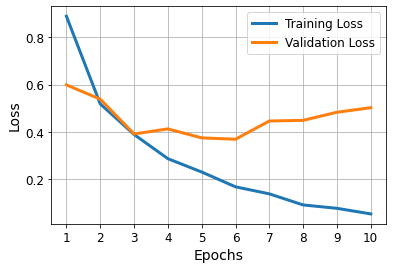

In [27]:
plot_graph(train1_loss, val1_loss, "Loss")

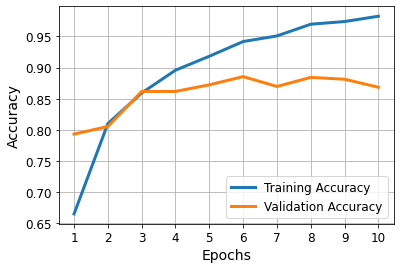

In [28]:
plot_graph(train1_acc, val1_acc, "Accuracy")

In [10]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"), 
    tf.keras.layers.Dense(8, activation="softmax")
])

In [11]:
# 5(a) - Decrease the learning rate (compared with the baseline model in Question Part 2)
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(optimizer = model_optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
history2 = model2.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/10
389/389 [==============================] - 102s 260ms/step - loss: 1.0803 - accuracy: 0.5944 - val_loss: 0.7147 - val_accuracy: 0.7436
Epoch 2/10
389/389 [==============================] - 100s 256ms/step - loss: 0.6219 - accuracy: 0.7736 - val_loss: 0.5614 - val_accuracy: 0.8035
Epoch 3/10
389/389 [==============================] - 100s 256ms/step - loss: 0.5345 - accuracy: 0.8024 - val_loss: 0.5250 - val_accuracy: 0.8109
Epoch 4/10
389/389 [==============================] - 99s 255ms/step - loss: 0.4848 - accuracy: 0.8213 - val_loss: 0.5116 - val_accuracy: 0.8144
Epoch 5/10
389/389 [==============================] - 102s 261ms/step - loss: 0.4481 - accuracy: 0.8383 - val_loss: 0.4732 - val_accuracy: 0.8295
Epoch 6/10
389/389 [==============================] - 101s 259ms/step - loss: 0.4210 - accuracy: 0.8476 - val_loss: 0.5358 - val_accuracy: 0.8022
Epoch 7/10
389/389 [==============================] - 105s 271ms/step - loss: 0.3832 - accuracy: 0.8653 - val_loss: 0.4432 - 

In [29]:
# train2_loss = np.asarray(history2.history["loss"])
# train2_acc = np.asarray(history2.history["accuracy"])
# val2_loss = np.asarray(history2.history["val_loss"])
# val2_acc = np.asarray(history2.history["val_accuracy"])

train2_loss = np.array([1.0803, 0.6219, 0.5345, 0.4848, 0.4481, 0.4210, 0.3832, 0.3599, 0.3343, 0.3242])
train2_acc = np.array([0.5944, 0.7736, 0.8024, 0.8213, 0.8383, 0.8476, 0.8653, 0.8736, 0.8810, 0.8884])
val2_loss = np.array([0.7147, 0.5614, 0.5250, 0.5116, 0.4732, 0.5358, 0.4432, 0.4317, 0.4939, 0.4257])
val2_acc = np.array([0.7436, 0.8035, 0.8109, 0.8144, 0.8295, 0.8022, 0.8424, 0.8488, 0.8257, 0.8604])

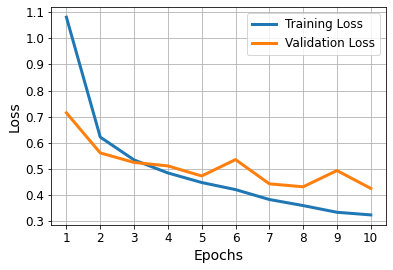

In [30]:
plot_graph(train2_loss, val2_loss, "Loss")

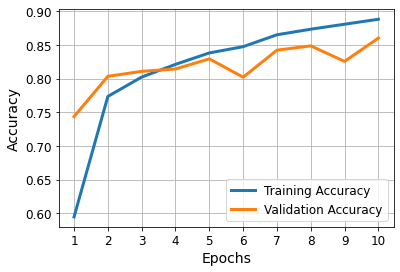

In [31]:
plot_graph(train2_acc, val2_acc, "Accuracy")

In [38]:
def compare_learning_rate (arrlr1, arrlr2, arrlr3, comtype) :
    figure, axis = plt.subplots()
    num_epochs = np.linspace(1, len(arrlr1), num = len(arrlr1)).astype(int)
    axis.plot(num_epochs, arrlr1, label = "%s (LR = 0.0001)" % comtype, linewidth = 3)
    axis.plot(num_epochs, arrlr2, label = "%s (LR = 0.0005)" % comtype, linewidth = 3)
    axis.plot(num_epochs, arrlr3, label = "%s (LR = 0.0010)" % comtype, linewidth = 3)
    axis.set_xlabel("Epochs", fontsize = 14)
    axis.set_ylabel(comtype, fontsize = 14)
    axis.grid()
    # figure.set_size_inches(8, 6)
    plt.xticks(num_epochs, fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return None

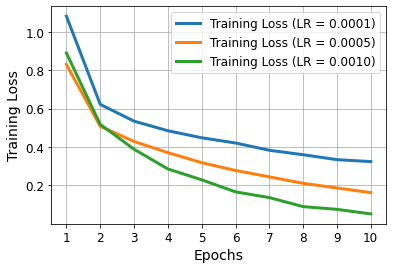

In [39]:
# 5(b)
compare_learning_rate(train2_loss, train_loss, train1_loss, "Training Loss")

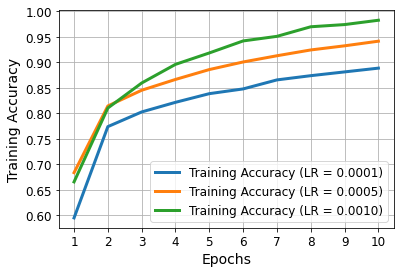

In [40]:
# 5(b)
compare_learning_rate(train2_acc, train_acc, train1_acc, "Training Accuracy")

### Question 5 (b) Comments: 
Given the above Training (Loss/Accuracy) comparison plots, we can see that when the learning rate increases, the slopes of training loss/accuracy will also increase, which means that the training loss will decrease faster, and the training accuracy will increase faster.  
However, according to the Validation (Loss/Accuracy) comparison plots shown below, although we can still observe that a larger learning rate can help model decrease validation loss faster and increase validation accuracy faster, the slopes of validation loss/accuracy have very explicit fluctuations. Therefore, the trends observed from training loss/accuracy are not that stable considering validation loss/accuracy.

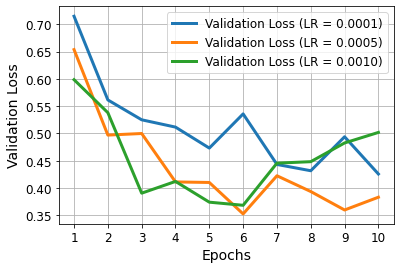

In [41]:
# 5(b)
compare_learning_rate(val2_loss, val_loss, val1_loss, "Validation Loss")

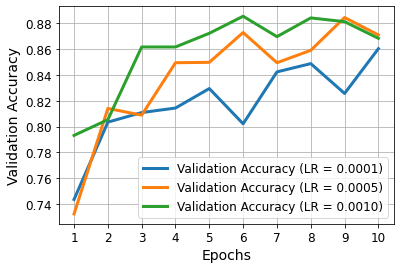

In [42]:
# 5(b)
compare_learning_rate(val2_acc, val_acc, val1_acc, "Validation Accuracy")

## 6. Adding Batch Norm
Fix a value of the learning rate and try adding Batch Normalization after layers 2 and 5. Does it improve the performance of your model? Explain briefly.

In [8]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.BatchNormalization(momentum=0.7), # Add Batch Norm after Layer 2
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.BatchNormalization(momentum=0.7), # Add Batch Norm after Layer 5
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"), 
    tf.keras.layers.Dense(8, activation="softmax")
])

In [9]:
# Fix the learning rate = 0.0005 in accordance with the baseline model from Question Part 2.
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model6.compile(optimizer = model_optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
history6 = model6.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data = (x_val, y_val))

Epoch 1/10
389/389 [==============================] - 115s 296ms/step - loss: 0.7343 - accuracy: 0.7526 - val_loss: 0.5114 - val_accuracy: 0.8231
Epoch 2/10
389/389 [==============================] - 116s 297ms/step - loss: 0.3397 - accuracy: 0.8764 - val_loss: 0.3656 - val_accuracy: 0.8723
Epoch 3/10
389/389 [==============================] - 112s 287ms/step - loss: 0.1855 - accuracy: 0.9338 - val_loss: 0.5340 - val_accuracy: 0.8527
Epoch 4/10
389/389 [==============================] - 112s 288ms/step - loss: 0.1062 - accuracy: 0.9641 - val_loss: 0.3217 - val_accuracy: 0.9019
Epoch 5/10
389/389 [==============================] - 112s 287ms/step - loss: 0.0580 - accuracy: 0.9809 - val_loss: 0.4636 - val_accuracy: 0.8694
Epoch 6/10
389/389 [==============================] - 112s 287ms/step - loss: 0.0548 - accuracy: 0.9808 - val_loss: 0.4340 - val_accuracy: 0.8791
Epoch 7/10
389/389 [==============================] - 114s 293ms/step - loss: 0.0336 - accuracy: 0.9886 - val_loss: 0.4843 -

In [43]:
# train6_loss = np.asarray(history6.history["loss"])
# train6_acc = np.asarray(history6.history["accuracy"])
# val6_loss = np.asarray(history6.history["val_loss"])
# val6_acc = np.asarray(history6.history["val_accuracy"])

train6_loss = np.array([0.7343, 0.3397, 0.1855, 0.1062, 0.0580, 0.0548, 0.0336, 0.0535, 0.0813, 0.0528])
train6_acc = np.array([0.7526, 0.8764, 0.9338, 0.9641, 0.9809, 0.9808, 0.9886, 0.9811, 0.9765, 0.9821])
val6_loss = np.array([0.5114, 0.3656, 0.5340, 0.3217, 0.4636, 0.4340, 0.4843, 0.5177, 0.6721, 0.5873])
val6_acc = np.array([0.8231, 0.8723, 0.8527, 0.9019, 0.8694, 0.8791, 0.8733, 0.8813, 0.8623, 0.8916])

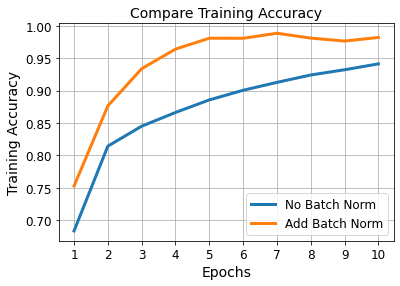

In [58]:
compare_models(train_acc, train6_acc, "Training Accuracy", ["No Batch Norm", "Add Batch Norm"])

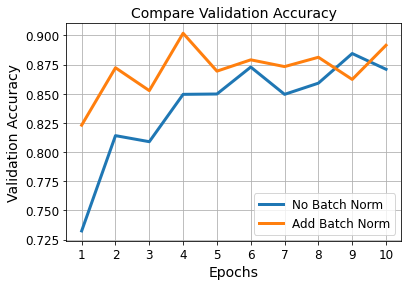

In [59]:
compare_models(val_acc, val6_acc, "Validation Accuracy", ["No Batch Norm", "Add Batch Norm"])

In [61]:
print("The best Validation Accuracy of the model without Batch Normalization is %.4f" % np.max(val_acc))
print("The best Validation Accuracy of the model with    Batch Normalization is %.4f" % np.max(val6_acc))

The best Validation Accuracy of the model without Batch Normalization is 0.8845
The best Validation Accuracy of the model with    Batch Normalization is 0.9019


### Question 6 Explanation: 
Based on the above comparison results, we can conclude that Batch Normalization does help improve the performance of my model. I think there are 2 major improvements. Firstly, the model with Batch Norm achieves a higher validation accuracy over 90%. Secondly, we can see that model with Batch Norm converges faster than the model without Batch Norm, which means that Batch Normalization can accelerate model training.  
To explain the reasons why Batch Norm could work, firstly, we need to know that sometimes training deep neural networks is difficult because updating earlier layers' weights might cause the distribution of later layers' weights to shift, known as internal covariate shift. Batch Normalization can reset the layer to which it is applied by normalizing to zero mean and one variance, which helps reduce the internal covariate shift. The internal covariate shift is reduced, so that training a deep neural network is easier, and a higher validation accuracy can also be expected. 

## 7. Data Augmetation
Now, instead of giving the dataset directly to the network, augment it first using:
```
keras.preprocessing.image.ImageDataGenerator
```
Specifically, use vertical and horizontal flips and 20 degrees rotation. We also want to normalise the data. Feel free to consult the documentation for this function.
What effect does this have on your model?

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"), 
    tf.keras.layers.Dense(8, activation="softmax")
])

In [23]:
datagen_train = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True, 
                                   rotation_range = 20, 
                                   featurewise_center = True,
                                   featurewise_std_normalization = True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip = True, 
                                 vertical_flip = True, 
                                 rotation_range = 20, 
                                 featurewise_center = True,
                                 featurewise_std_normalization = True)
datagen_val.fit(x_val)

In [24]:
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model7.compile(optimizer = model_optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

history7 = model7.fit(datagen_train.flow(x_train, y_train, batch_size = 32), 
                      validation_data = datagen_val.flow(x_val, y_val, batch_size = 32), 
                      epochs = 10)

Epoch 1/10
389/389 [==============================] - 105s 268ms/step - loss: 0.7110 - accuracy: 0.7321 - val_loss: 0.4605 - val_accuracy: 0.8382
Epoch 2/10
389/389 [==============================] - 105s 270ms/step - loss: 0.4389 - accuracy: 0.8394 - val_loss: 0.3939 - val_accuracy: 0.8537
Epoch 3/10
389/389 [==============================] - 106s 272ms/step - loss: 0.3612 - accuracy: 0.8686 - val_loss: 0.3530 - val_accuracy: 0.8713
Epoch 4/10
389/389 [==============================] - 105s 269ms/step - loss: 0.3102 - accuracy: 0.8870 - val_loss: 0.2857 - val_accuracy: 0.8961
Epoch 5/10
389/389 [==============================] - 104s 268ms/step - loss: 0.2758 - accuracy: 0.9043 - val_loss: 0.3921 - val_accuracy: 0.8617
Epoch 6/10
389/389 [==============================] - 105s 269ms/step - loss: 0.2387 - accuracy: 0.9145 - val_loss: 0.2592 - val_accuracy: 0.9048
Epoch 7/10
389/389 [==============================] - 104s 268ms/step - loss: 0.2192 - accuracy: 0.9208 - val_loss: 0.2035 -

In [62]:
# train7_loss = np.asarray(history7.history["loss"])
# train7_acc = np.asarray(history7.history["accuracy"])
# val7_loss = np.asarray(history7.history["val_loss"])
# val7_acc = np.asarray(history7.history["val_accuracy"])

train7_loss = np.array([0.7110, 0.4389, 0.3612, 0.3102, 0.2758, 0.2387, 0.2192, 0.2036, 0.1873, 0.1802])
train7_acc = np.array([0.7321, 0.8394, 0.8686, 0.8870, 0.9043, 0.9145, 0.9208, 0.9275, 0.9325, 0.9348])
val7_loss = np.array([0.4605, 0.3939, 0.3530, 0.2857, 0.3921, 0.2592, 0.2035, 0.2151, 0.2087, 0.2223])
val7_acc = np.array([0.8382, 0.8537, 0.8713, 0.8961, 0.8617, 0.9048, 0.9299, 0.9241, 0.9263, 0.9215])

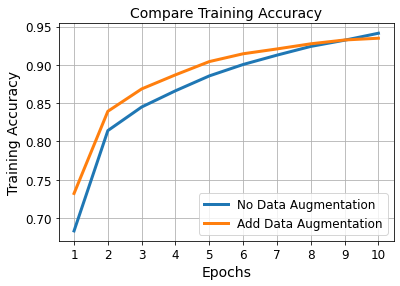

In [63]:
compare_models(train_acc, train7_acc, "Training Accuracy", ["No Data Augmentation", "Add Data Augmentation"])

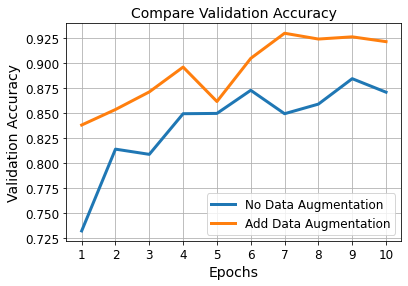

In [64]:
compare_models(val_acc, val7_acc, "Validation Accuracy", ["No Data Augmentation", "Add Data Augmentation"])

In [65]:
print("The best Validation Accuracy of the model without Data Augmentation is %.4f" % np.max(val_acc))
print("The best Validation Accuracy of the model with    Data Augmentation is %.4f" % np.max(val7_acc))

The best Validation Accuracy of the model without Data Augmentation is 0.8845
The best Validation Accuracy of the model with    Data Augmentation is 0.9299


### Question 7 Explanation: 
Based on the above comparison results, Data Augmentation can improve my model's Validation Accuracy by over 4%, achieving almost 93%. Data Augmentation helps improve the performance of my model, so that I think the effect is positive.

## 8. Custom layers
In one of the TA sessions, we briefly went over how to implement a custom layer -- specifically, we re-implemented the Dense (or fully-connected) layer. In this part, we will get more practice implementing custom layers.

Please reimplement a simplified version of `tf.keras.layers.Conv2D` using `tf.nn.conv2d`: https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

Note carefully the difference between these two tf constructs. In particular, `tf.keras.layers.Conv2D` is a high-level implementation of the 2D convolution that defines all the parameters under the hood, while `tf.nn.conv2d` requires you to define your own convolutional kernels via `tf.Variable` (you may also use the `add_weight` function if you desire). 
- Your implementation should also include a bias variable, consistent with the default behavior of `tf.keras.layers.Conv2D`.
- Your constructor should accept 4 parameters: filters, kernel_size, strides, and activation.
- You may hard-code the padding as `'SAME'`
- You do not have to implement the string shortcuts for the activations (e.g., if your code handles `tf.nn.relu` but not `'relu'`, that's okay).
- For simplicity, you may assume that kernel_size and strides are integers (i.e., as opposed to lists).
- Initialize all weights using the standard normal distribution.

Note that since you only have to deal with the above 5 input arguments, your implementation will not be as sophisticated as `tf.keras.layers.Conv2D`, which contains many other input arguments. Rather, the point of this exercise is for you to get a better understanding of what tf is doing under the hood so that you are not just blindly using their high-level functions.

Feel free to refer to the notebook from the TA session or any online tf documentation, though please do not copy the source code from tf's native implementation of Conv2D.

After you're done, repeat the CNN defined above, substituting all instances of `tf.keras.layers.Conv2D` with your implementation, and run for 10 epochs. It's okay if you don't get the same accuracy, but it should still improve. Also print out the `.summary()` command to ensure that the number of parameters is the same as before.

In [8]:
class Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, activation):
        super(Conv2D, self).__init__()
        self.filters_out = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = activation
    
    def build(self, input_shape):
        # expect the input_shape to be (batch_size, height, width, filters_previous)
        filters_in = input_shape[-1]
        weight_init = tf.random_normal_initializer()
        self.bias = tf.Variable(initial_value=weight_init(shape=(self.filters_out,)), dtype="float32", trainable=True)
        self.kernels = tf.Variable(initial_value=weight_init(shape=(self.kernel_size, self.kernel_size, filters_in, self.filters_out)), 
                                   dtype="float32", trainable=True)
    
    def call(self, inputs):
        xout = tf.nn.conv2d(inputs, self.kernels, strides = self.strides, padding = "SAME") + self.bias
        if self.activation == "tanh" :
            out = tf.nn.tanh(xout)
        if self.activation == "relu" :
            out = tf.nn.relu(xout)
        if self.activation == "leaky_relu" :
            out = tf.nn.leaky_relu(xout)
        return out

In [9]:
# copy and paste an earlier training script, and replace the native conv2Ds with yours
model8 = tf.keras.models.Sequential([
    Conv2D(filters=4, kernel_size=5, strides=1, activation="relu"), 
    Conv2D(filters=8, kernel_size=5, strides=1, activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    Conv2D(filters=16, kernel_size=5, strides=1, activation="relu"), 
    Conv2D(filters=32, kernel_size=5, strides=1, activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"), 
    tf.keras.layers.Dense(8, activation="softmax")
])

In [10]:
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model8.compile(optimizer = model_optimizer, 
               loss = "categorical_crossentropy", 
               metrics = ["accuracy"])

In [11]:
history8 = model8.fit(x_train, y_train, 
                      epochs = 10, 
                      batch_size = 32, 
                      validation_data = (x_val, y_val))

Epoch 1/10
389/389 [==============================] - 99s 254ms/step - loss: 0.9341 - accuracy: 0.6472 - val_loss: 0.5972 - val_accuracy: 0.7842
Epoch 2/10
389/389 [==============================] - 101s 260ms/step - loss: 0.5244 - accuracy: 0.8079 - val_loss: 0.4523 - val_accuracy: 0.8479
Epoch 3/10
389/389 [==============================] - 104s 267ms/step - loss: 0.3804 - accuracy: 0.8648 - val_loss: 0.3690 - val_accuracy: 0.8771
Epoch 4/10
389/389 [==============================] - 102s 262ms/step - loss: 0.3232 - accuracy: 0.8850 - val_loss: 0.4161 - val_accuracy: 0.8598
Epoch 5/10
389/389 [==============================] - 98s 251ms/step - loss: 0.2725 - accuracy: 0.9033 - val_loss: 0.3510 - val_accuracy: 0.8778
Epoch 6/10
389/389 [==============================] - 97s 250ms/step - loss: 0.2485 - accuracy: 0.9081 - val_loss: 0.3638 - val_accuracy: 0.8765
Epoch 7/10
389/389 [==============================] - 100s 257ms/step - loss: 0.2162 - accuracy: 0.9225 - val_loss: 0.3304 - va

In [69]:
train8_acc = np.array([0.6472, 0.8079, 0.8648, 0.8850, 0.9033, 0.9081, 0.9225, 0.9307, 0.9410, 0.9476])
val8_acc = np.array([0.7842, 0.8479, 0.8771, 0.8598, 0.8778, 0.8765, 0.8778, 0.8922, 0.8916, 0.8971])

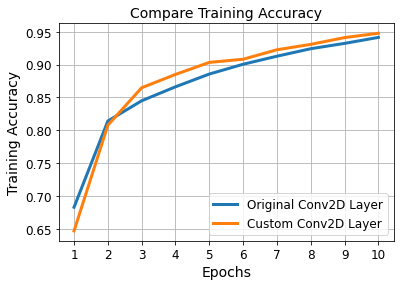

In [70]:
compare_models(train_acc, train8_acc, "Training Accuracy", ["Original Conv2D Layer", "Custom Conv2D Layer"])

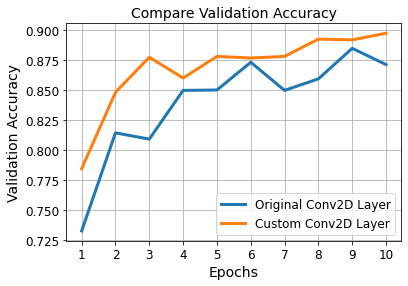

In [71]:
compare_models(val_acc, val8_acc, "Validation Accuracy", ["Original Conv2D Layer", "Custom Conv2D Layer"])

In [72]:
print("The best Validation Accuracy of the model with Original   Conv2D Layers is %.4f" % np.max(val_acc))
print("The best Validation Accuracy of the model with Customized Conv2D Layers is %.4f" % np.max(val8_acc))

The best Validation Accuracy of the model with Original   Conv2D Layers is 0.8845
The best Validation Accuracy of the model with Customized Conv2D Layers is 0.8971


Based on the above comparison results, we can see that the training processes of these two models are very similar. We can also see that the model with my Customized Conv2D Layers has a little bit better Validation Accuracy.

In [75]:
model8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 4)       104       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       808       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

Based on the above summary information, we can confirm that the number of parameters is the same as before.

##** Bonus question: Custom layer for Fourier filtering

Note: this problem requires some careful bug-checking

Now, we will implement a custom layer that doesn't exist in keras -- Fourier filtering. Your layer should apply the 2D Fourier transform (`tf.signal.fft2d`) to each channel of the input, multiply element-wise by an optimizable mask (a different one for each channel), apply the 2D inverse Fourier transform (`tf.signal.ifft2d`), and then take the absolute value. Note: 
- You will have to use the tf versions of all operations, NOT the numpy versions. 
- The fft2d operations in tensorflow are done on the LAST two dimensions, which is at odds with the default dimension ordering of CNNs. Thus, you will need to use `tf.transpose` on the input and then transpose back after the filtering operation.
- Use dtype `tf.complex64`, which is basically a combination of two `tf.float32`s. You will have to explicitly cast between these two data types, because the input/output will be `tf.float32`, but intermediate steps will be `tf.complex64`.

Initialize your optimizable Fourier masks using a binary circular mask (1's inside the circle, 0's outside), with a radius given by 1/4 of the square image dimension (you can round if not divisible by 4). 

After defining this custom layer, copy your previously defined CNN above and insert this new layer as the first layer. To verify that your layer is working correctly, plot some example outputs of the first layer.

In [8]:
class FourierFilter(tf.keras.layers.Layer):
    def __init__(self):
        super(FourierFilter, self).__init__()
    
    def build(self, input_shape):
        # expect the input_shape to be (batch_size, height, width, filters_previous)
        
        #####################################################################################################
        # Note: I do realize that I have to use the tf versions for all operations.
        # Here I ONLY use numpy to initialize the binary circular mask, 
        # because it is difficult to assign values to Tensorflow Tensors. 
        # After mask initialization, I immediately convert the numpy mask into a tf Tensor.
        height = input_shape[1]
        width = input_shape[2]
        filters_in = input_shape[3]
        np_mask = np.zeros((filters_in, height, width))
        center_h = int(height / 2) - 1
        center_w = int(width / 2) - 1
        radius = int(height / 4)
        for i in range(filters_in) :
            for j in range(height) :
                for k in range(width) :
                    curr_dist = np.sqrt(((j - center_h)**2) + ((k - center_w)**2))
                    if curr_dist <= radius :
                        np_mask[i, j, k] = 1
        ######################################################################################################
        
        tensor_mask = tf.convert_to_tensor(np_mask, dtype = tf.complex64)
        
        self.optmask = tf.Variable(initial_value = tensor_mask, dtype = "complex64", trainable = True)
    
    def call(self, inputs):
        # In this method, I indeed use Tensorflow versions for all operations
        cast_inputs = tf.cast(inputs, dtype = tf.complex64)
        transpose_in = tf.transpose(cast_inputs, perm = [0, 3, 1, 2])
        
        outputs = tf.signal.fft2d(transpose_in)
        outputs = tf.math.multiply(outputs, self.optmask)
        outputs = tf.signal.ifft2d(outputs)
        outputs = tf.math.abs(outputs)
        
        transpose_out = tf.transpose(outputs, perm = [0, 2, 3, 1])
        cast_outputs = tf.cast(transpose_out, dtype = tf.float32)
        return cast_outputs

In [9]:
model9 = tf.keras.models.Sequential([
    
    # Insert this new Fourier Filter Layer as the first layer
    FourierFilter(),
    
    tf.keras.layers.Conv2D(filters=4, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding="valid"), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=64, activation="relu"), 
    tf.keras.layers.Dense(8, activation="softmax")
])

In [13]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

In [11]:
model9.build(input_shape = [32, 128, 128, 1])
layerout = [layer.output for layer in model9.layers[0:3]]
actmodel = models.Model(inputs = model9.input, outputs = layerout)
acts = actmodel.predict(x_val[0:32])
layer1out = acts[0]
print(layer1out.shape)

(32, 128, 128, 1)


In [14]:
def plot_examples (list_images) :
    plt.figure(figsize = (20, 10))
    list_columns = len(list_images)
    for i, image in enumerate(list_images) :
        plt.subplot(1, list_columns, i + 1)
        plt.axis("off")
        plt.imshow(image)
    return None

Here I just want to see what the first layer outputs could be with the initialized circular binary mask. Please note that these first layer output examples are extracted BEFORE model training. Meanwhile I also plot the original images for comparison.  
Please continue to the following blocks to see the extracted first layer outputs AFTER model training.

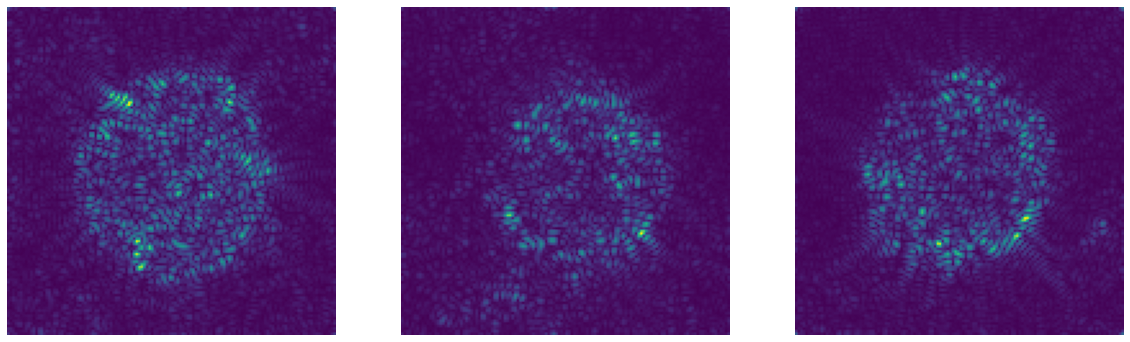

In [16]:
# Some example outputs of the first layer BEFORE model training
plot_examples([layer1out[0,:,:,0], layer1out[10,:,:,0], layer1out[20,:,:,0]])

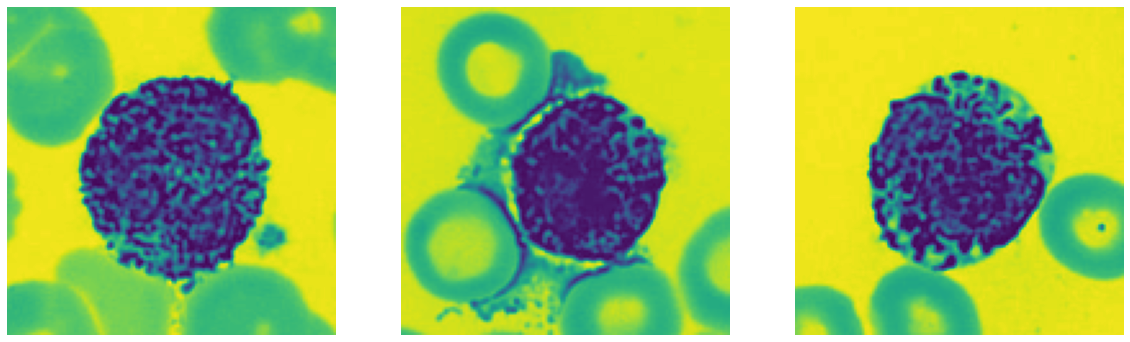

In [17]:
# The original example images
plot_examples([x_val[0,:,:,0], x_val[10,:,:,0], x_val[20,:,:,0]])

In [10]:
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model9.compile(optimizer = model_optimizer, 
               loss = "categorical_crossentropy", 
               metrics = ["accuracy"])

In [11]:
history9 = model9.fit(x_train, y_train, 
                      epochs = 10, 
                      batch_size = 32, 
                      validation_data = (x_val, y_val))

Epoch 1/10
389/389 [==============================] - 129s 330ms/step - loss: 1.3679 - accuracy: 0.4500 - val_loss: 0.9626 - val_accuracy: 0.6394
Epoch 2/10
389/389 [==============================] - 164s 422ms/step - loss: 0.8461 - accuracy: 0.6800 - val_loss: 0.7584 - val_accuracy: 0.7144
Epoch 3/10
389/389 [==============================] - 134s 346ms/step - loss: 0.6645 - accuracy: 0.7507 - val_loss: 0.8338 - val_accuracy: 0.6925
Epoch 4/10
389/389 [==============================] - 134s 343ms/step - loss: 0.5530 - accuracy: 0.7942 - val_loss: 0.6434 - val_accuracy: 0.7623
Epoch 5/10
389/389 [==============================] - 130s 335ms/step - loss: 0.4869 - accuracy: 0.8205 - val_loss: 0.6120 - val_accuracy: 0.7842
Epoch 6/10
389/389 [==============================] - 152s 391ms/step - loss: 0.4066 - accuracy: 0.8505 - val_loss: 0.6178 - val_accuracy: 0.7832
Epoch 7/10
389/389 [==============================] - 148s 381ms/step - loss: 0.3591 - accuracy: 0.8716 - val_loss: 0.6198 -

In [15]:
layerout = [layer.output for layer in model9.layers[0:3]]
actmodel = models.Model(inputs = model9.input, outputs = layerout)
acts = actmodel.predict(x_val[0:32])
layer1out = acts[0]
print(layer1out.shape)

(32, 128, 128, 1)


Here I plot some example outputs of the first layer AFTER model training.

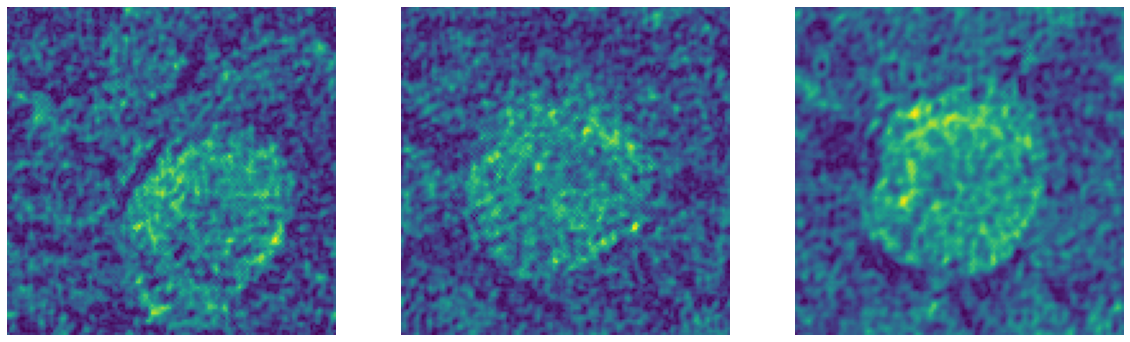

In [16]:
# Some example outputs of the first layer AFTER model training
plot_examples([layer1out[0,:,:,0], layer1out[10,:,:,0], layer1out[20,:,:,0]])

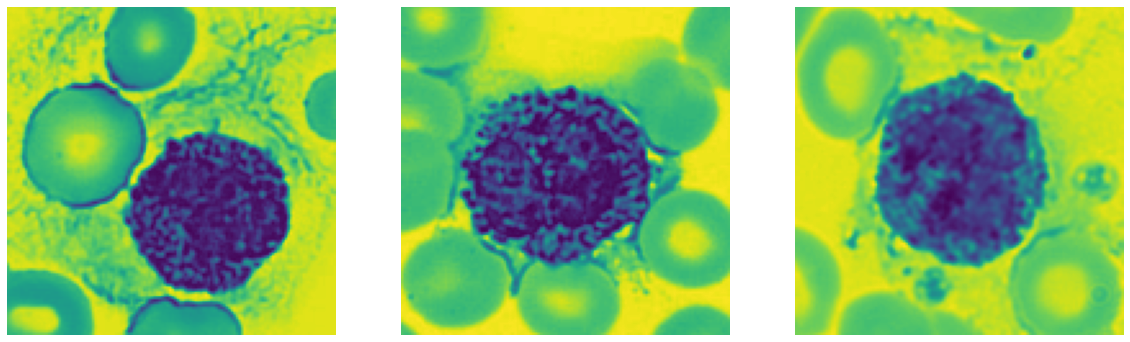

In [17]:
# The original example images
plot_examples([x_val[0,:,:,0], x_val[10,:,:,0], x_val[20,:,:,0]])

Another training and validation processes for my model with Customized Fourier Filter Layer are shown below.  
The model summary information has also been listed.

In [10]:
model_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model9.compile(optimizer = model_optimizer, 
               loss = "categorical_crossentropy", 
               metrics = ["accuracy"])

In [11]:
history9 = model9.fit(x_train, y_train, 
                      epochs = 10, 
                      batch_size = 32, 
                      validation_data = (x_val, y_val))

Epoch 1/10
389/389 [==============================] - 132s 339ms/step - loss: 1.3790 - accuracy: 0.4613 - val_loss: 0.7603 - val_accuracy: 0.7186
Epoch 2/10
389/389 [==============================] - 133s 343ms/step - loss: 0.6615 - accuracy: 0.7521 - val_loss: 0.6337 - val_accuracy: 0.7697
Epoch 3/10
389/389 [==============================] - 138s 354ms/step - loss: 0.5414 - accuracy: 0.7990 - val_loss: 0.6354 - val_accuracy: 0.7723
Epoch 4/10
389/389 [==============================] - 137s 353ms/step - loss: 0.4581 - accuracy: 0.8362 - val_loss: 0.5137 - val_accuracy: 0.8160
Epoch 5/10
389/389 [==============================] - 137s 353ms/step - loss: 0.3800 - accuracy: 0.8638 - val_loss: 0.5107 - val_accuracy: 0.8176
Epoch 6/10
389/389 [==============================] - 134s 346ms/step - loss: 0.3049 - accuracy: 0.8900 - val_loss: 0.4938 - val_accuracy: 0.8289
Epoch 7/10
389/389 [==============================] - 138s 354ms/step - loss: 0.2549 - accuracy: 0.9098 - val_loss: 0.5949 -

In [12]:
model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fourier_filter (FourierFilt  (None, 128, 128, 1)      16384     
 er)                                                             
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 4)       104       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       808       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        3216      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        1